In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

d:\Application\Conda\envs\geoneuro\lib\site-packages\geopandas\_compat.py:153: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\Cover\AppData\Local\Temp\ipykernel_37784\1960879352.py:3: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [2]:
# read in the travel chain data
chain_pro = pd.read_csv('./data/sample/chain_pro_new_plus.csv')

In [3]:
stay = chain_pro[~chain_pro.isMove].copy()

stay.drop(columns=['isMove', 'poi_d', 'lambda_d', 'phi_d', 'mode'], inplace=True)
stay.rename(columns={'poi_o': 'poi', 'lambda_o': 'lambda', 'phi_o': 'phi'}, inplace=True)

In [4]:
stay

,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0
...,...,...,...,...,...,...,...,...,...
19361,102181433,20231229,3,2023-12-29 22:48:43,2023-12-29 23:59:03,0,113.973390,22.594425,1.0
19362,102181433,20231230,0,2023-12-30 00:00:05,2023-12-30 20:14:33,0,113.973390,22.594425,1.0
19364,102181433,20231230,1,2023-12-30 20:21:35,2023-12-30 23:58:19,0,113.973390,22.594425,1.0
19365,102181433,20231231,0,2023-12-31 00:00:22,2023-12-31 21:31:20,0,113.973390,22.594425,1.0


## Label the states

In [5]:
# 将经纬度(lambda/phi)转换为 EPSG:32650 投影坐标(米)，生成 x/y
# 输入: 已存在的 DataFrame `stay`，包含列 ['lambda','phi']

gdf = gpd.GeoDataFrame(
    stay.copy(),
    geometry=gpd.points_from_xy(stay['lambda'], stay['phi']),
    crs='EPSG:4326'
)

# 转换到 UTM Zone 50N (EPSG:32650)
gdf = gdf.to_crs(epsg=32650)

# 提取投影坐标为 x/y 列
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# 工作副本，后续聚类在 gdf 上进行
gdf.head()


,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,x,y
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (194256.862 2508484.714),194256.862442,2.508485e+06
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06


In [6]:
# 对每人分组，将点位在 200m 内均匀随机偏置后，用 HDBSCAN(min_cluster_size=5) 聚类
# 输出: DataFrame `stay_clustered`，新增列 'cluster_id'，-1 表示噪声

# 安装/导入 hdbscan
import hdbscan

# 为可复现实验设置全局随机数发生器（不固定也可删除该行）
RNG = np.random.default_rng(114514)

def jitter_within_radius(xy: np.ndarray, max_radius_m: float, rng: np.random.Generator) -> np.ndarray:
    """在半径 max_radius_m 的圆内，做均匀随机偏置（面积均匀）。"""
    n = xy.shape[0]
    angles = rng.uniform(0.0, 2.0 * np.pi, size=n)
    radii = max_radius_m * np.sqrt(rng.uniform(0.0, 1.0, size=n))
    offsets = np.column_stack([radii * np.cos(angles), radii * np.sin(angles)])
    return xy + offsets


def cluster_one_person(df_person: pd.DataFrame) -> pd.DataFrame:
    df_person = df_person.copy()
    xy = df_person[['x', 'y']].to_numpy(dtype=float)
    xy_jittered = jitter_within_radius(xy, max_radius_m=200.0, rng=RNG)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=6, min_samples=3, metric='euclidean')
    labels = clusterer.fit_predict(xy_jittered)
    df_person['cluster_id'] = labels
    return df_person

# 分组执行聚类（按 who）
stay_clustered = gdf.groupby('who', group_keys=False).apply(cluster_one_person)

# 生成一个紧凑的簇编号（可选）：将每个 who 内的簇标签映射到 0..K-1（保留噪声为 -1）
# 如需跨用户全局唯一，可删除以下代码。
def relabel_per_person(df_person: pd.DataFrame) -> pd.DataFrame:
    df_person = df_person.copy()
    labels = df_person['cluster_id'].to_numpy()
    unique_labels = [l for l in np.unique(labels) if l != -1]
    mapping = {l: i for i, l in enumerate(unique_labels)}
    df_person['cluster_id'] = np.where(labels == -1, -1, pd.Series(labels).map(mapping).to_numpy())
    return df_person

stay_clustered = stay_clustered.groupby('who', group_keys=False).apply(relabel_per_person)


d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Application\Conda\envs\geoneuro\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

In [7]:
# 结果预览与简单统计
from IPython.display import display

display(stay_clustered.head(10))

# 每个 who 的簇数量与噪声占比（可选）
cluster_stats = (
    stay_clustered
    .assign(is_noise=lambda d: d['cluster_id'].eq(-1))
    .groupby('who')
    .agg(num_points=('cluster_id', 'size'),
         num_clusters=('cluster_id', lambda s: s.loc[s.ne(-1)].nunique()),
         noise_ratio=('is_noise', 'mean'))
    .reset_index()
)

display(cluster_stats.head(10))


,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,x,y,cluster_id
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06,10.0
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (194256.862 2508484.714),194256.862442,2.508485e+06,10.0
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
9,1102234,20230302,2,2023-03-02 22:23:22,2023-03-02 23:54:44,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
10,1102234,20230303,0,2023-03-03 07:01:26,2023-03-03 07:36:17,13,114.034653,22.665482,0.0,POINT (195266.699 2509530.081),195266.698607,2.509530e+06,8.0
12,1102234,20230303,1,2023-03-03 07:46:08,2023-03-03 21:29:21,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
14,1102234,20230303,2,2023-03-03 21:44:41,2023-03-03 23:20:31,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
15,1102234,20230304,0,2023-03-04 07:58:33,2023-03-04 08:50:21,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06,10.0


,who,num_points,num_clusters,noise_ratio
0,1102234,730,13,0.073973
1,4116450,800,6,0.037500
2,6945721,876,22,0.098174
3,10013454,143,2,0.181818
4,23951036,1064,18,0.073308
5,25679537,810,16,0.088889
6,26564845,481,7,0.051975
7,44777185,305,3,0.032787
8,47319758,342,10,0.210526
9,54636959,297,2,0.168350


In [8]:
# 地理可视化：为每个人分别创建交互式地图，不同簇用不同颜色标记
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 确保 stay_clustered 有经纬度信息（如果只有投影坐标，需要转换回来）
# 由于 stay_clustered 是从 gdf 来的，而 gdf 是从 stay 来的，应该还有原始的 lambda 和 phi
# 如果没有，需要从投影坐标转换回经纬度
if 'lambda' not in stay_clustered.columns or 'phi' not in stay_clustered.columns:
    # 从投影坐标转换回 WGS84
    gdf_wgs84 = stay_clustered.to_crs(epsg=4326)
    stay_clustered['lambda'] = gdf_wgs84.geometry.x
    stay_clustered['phi'] = gdf_wgs84.geometry.y

# 为簇创建颜色映射（使用 plotly 的离散颜色序列）
def get_cluster_colors(n_clusters):
    """为簇生成颜色，噪声用灰色"""
    # 使用 plotly 的定性颜色序列
    colors = px.colors.qualitative.Set3
    if n_clusters <= len(colors):
        return colors[:n_clusters]
    # 如果需要更多颜色，使用循环
    return (colors * ((n_clusters // len(colors)) + 1))[:n_clusters]

def plot_person_clusters(person_id, df_person):
    """为单个个体创建聚类可视化地图"""
    # 获取该个体的所有簇（排除噪声）
    unique_clusters = sorted([c for c in df_person['cluster_id'].unique() if c != -1])
    n_clusters = len(unique_clusters)
    
    if n_clusters == 0:
        print(f"个体 {person_id} 没有有效的簇（全部为噪声）")
        return None
    
    # 创建颜色映射
    cluster_colors = get_cluster_colors(n_clusters)
    color_map = {cluster: cluster_colors[i] for i, cluster in enumerate(unique_clusters)}
    color_map[-1] = 'gray'  # 噪声用灰色
    
    # 创建图形
    fig = go.Figure()
    
    # 为每个簇添加一个散点图层
    for cluster_id in unique_clusters:
        cluster_data = df_person[df_person['cluster_id'] == cluster_id]
        fig.add_trace(go.Scattermapbox(
            lat=cluster_data['phi'],
            lon=cluster_data['lambda'],
            mode='markers',
            marker=dict(
                size=8,
                color=color_map[cluster_id],
                opacity=0.7
            ),
            name=f'簇 {cluster_id}',
            text=[f"簇: {cluster_id}<br>POI: {poi}<br>日期: {date}" 
                  for poi, date in zip(cluster_data['poi'], cluster_data['date'])],
            hovertemplate='%{text}<extra></extra>',
            showlegend=True
        ))
    
    # 添加噪声点（如果有）
    noise_data = df_person[df_person['cluster_id'] == -1]
    if len(noise_data) > 0:
        fig.add_trace(go.Scattermapbox(
            lat=noise_data['phi'],
            lon=noise_data['lambda'],
            mode='markers',
            marker=dict(
                size=6,
                color='gray',
                opacity=0.5,
                symbol='x'
            ),
            name='噪声点',
            text=[f"噪声点<br>POI: {poi}<br>日期: {date}" 
                  for poi, date in zip(noise_data['poi'], noise_data['date'])],
            hovertemplate='%{text}<extra></extra>',
            showlegend=True
        ))
    
    # 设置地图布局
    fig.update_layout(
        title=f'个体 {person_id} 的活动地点聚类可视化',
        mapbox=dict(
            style='carto-positron',  # 使用灰度底图（无彩色）
            center=dict(
                lat=df_person['phi'].mean(),
                lon=df_person['lambda'].mean()
            ),
            zoom=11
        ),
        height=600,
        width=1000,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    return fig

# 选择前几个个体进行可视化（可以根据需要调整）
sample_persons = stay_clustered['who'].unique()[:5]  # 可视化前5个个体

for person_id in sample_persons:
    df_person = stay_clustered[stay_clustered['who'] == person_id]
    fig = plot_person_clusters(person_id, df_person)
    if fig is not None:
        fig.show()


In [12]:
stay_clustered

,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,x,y,cluster_id
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (194414.952 2507882.981),194414.951879,2.507883e+06,10.0
2,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
4,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (194911.188 2508234.840),194911.187574,2.508235e+06,12.0
5,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (194256.862 2508484.714),194256.862442,2.508485e+06,10.0
7,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (197403.987 2512233.915),197403.987064,2.512234e+06,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19361,102181433,20231229,3,2023-12-29 22:48:43,2023-12-29 23:59:03,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0
19362,102181433,20231230,0,2023-12-30 00:00:05,2023-12-30 20:14:33,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0
19364,102181433,20231230,1,2023-12-30 20:21:35,2023-12-30 23:58:19,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0
19365,102181433,20231231,0,2023-12-31 00:00:22,2023-12-31 21:31:20,0,113.973390,22.594425,1.0,POINT (188806.744 2501783.830),188806.743693,2.501784e+06,3.0


In [33]:
# 可选：可视化特定个体或使用不同的地图样式
# 示例：可视化特定个体
# person_id = 1102234  # 替换为你想要可视化的个体ID
# df_person = stay_clustered[stay_clustered['who'] == person_id]
# fig = plot_person_clusters(person_id, df_person)
# if fig is not None:
#     fig.show()

# 可选：使用不同的地图样式（需要 mapbox token）
# 在 plot_person_clusters 函数中，可以将 style 改为：
# - 'open-street-map' (免费，不需要 token)
# - 'carto-positron' (免费，不需要 token)
# - 'carto-darkmatter' (免费，不需要 token)
# - 'stamen-terrain' (免费，不需要 token)
# - 'mapbox://styles/mapbox/streets-v11' (需要 mapbox token)


## import the built environment

In [9]:
builtenv_path = 'E:/Programming/Python/project_GeoComputation/data/Shapefile/BuiltEnvironmentShenzhen_wgs84.shp'
# use geopandas to read the shapefile of the path
builtenv = gpd.read_file(builtenv_path)
# fill the na with zero
builtenv.fillna(0, inplace=True)

In [10]:
hexcell_path = 'E:\Programming\Python\project_GeoComputation\data\Shapefile\H3Grid_res_9.shp'
hexcell = gpd.read_file(hexcell_path)

In [13]:
# 提取每个个体每个锚点（簇）的特征向量
# 步骤：
# 1. 将 stay_clustered 中的点与 hexcell 做空间连接，匹配到 h3 网格
# 2. 通过 h3 网格编号与 builtenv 连接，获取特征向量
# 3. 对每个个体的每个簇，将所有活动记录的特征向量求平均（不做 unique，自然加权）

# # 首先，确保 stay_clustered 有 geometry 列（用于空间连接）
# if 'geometry' not in stay_clustered.columns:
#     # 从经纬度创建 geometry
#     stay_clustered_gdf = gpd.GeoDataFrame(
#         stay_clustered,
#         geometry=gpd.points_from_xy(stay_clustered['lambda'], stay_clustered['phi']),
#         crs='EPSG:4326'
#     )
# else:
#     stay_clustered_gdf = gpd.GeoDataFrame(stay_clustered, crs='EPSG:4326')
    
stay_clustered_gdf = stay_clustered.to_crs(epsg=4326)

# 确保 hexcell 和 builtenv 的坐标系一致（都是 WGS84）
if hexcell.crs != 'EPSG:4326':
    hexcell = hexcell.to_crs(epsg=4326)
if builtenv.crs != 'EPSG:4326':
    builtenv = builtenv.to_crs(epsg=4326)

# 步骤1：空间连接，将点匹配到 h3 网格
print("正在将活动记录匹配到 h3 网格...")
stay_with_hex = gpd.sjoin(
    stay_clustered_gdf,
    hexcell,
    how='left',
    predicate='within'
)

# 检查是否有匹配失败的记录
unmatched = stay_with_hex[stay_with_hex.index_right.isna()]
if len(unmatched) > 0:
    print(f"警告：有 {len(unmatched)} 条记录未能匹配到 h3 网格")
    print(f"未匹配记录占比: {len(unmatched) / len(stay_with_hex):.2%}")

# 查看 hexcell 和 builtenv 的列名，确定关联字段
print("\nhexcell 的列名:")
print(hexcell.columns.tolist())
print("\nbuiltenv 的列名:")
print(builtenv.columns.tolist())


正在将活动记录匹配到 h3 网格...

hexcell 的列名:
['h3_index', 'geometry']

builtenv 的列名:
['base_h3', 'population', 'road_len_m', 'intersecti', 'landuse_en', 'bus_stop_c', 'metro_stat', 'poi_servic', 'poi_shoppi', 'poi_leisur', 'poi_cultur', 'poi_medica', 'poi_cateri', 'area_sum', 'plot_sum', 'area_ratio', 'plot_ratio', 'geometry']


In [14]:
# 步骤2：通过 h3 网格编号与 builtenv 连接
# 需要确定 hexcell 和 builtenv 的关联字段
# 通常可能是 'h3_index', 'h3', 'index', 'id' 等

# 先查看 hexcell 和 builtenv 的前几行，确定关联字段
print("hexcell 前几行:")
print(hexcell.head(2))
print("\nbuiltenv 前几行:")
print(builtenv.head(2))

# 查找可能的关联字段（通常包含 'h3' 或 'index' 的列）
hexcell_cols = [col for col in hexcell.columns if 'h3' in col.lower() or 'index' in col.lower() or 'id' in col.lower()]
builtenv_cols = [col for col in builtenv.columns if 'h3' in col.lower() or 'index' in col.lower() or 'id' in col.lower()]

print(f"\nhexcell 中可能的关联字段: {hexcell_cols}")
print(f"builtenv 中可能的关联字段: {builtenv_cols}")


hexcell 前几行:
          h3_index                                           geometry
0  89411c3ab8bffff  POLYGON ((113.92341 22.82436, 113.92197 22.823...
1  89411c06d43ffff  POLYGON ((114.04048 22.67635, 114.03905 22.675...

builtenv 前几行:
           base_h3    population   road_len_m  intersecti  landuse_en  \
0  89411c3ab8bffff      2.999800     0.000000           0    0.062359   
1  89411c06d43ffff  12562.099945  2128.529018          16    1.173550   

   bus_stop_c  metro_stat  poi_servic  poi_shoppi  poi_leisur  poi_cultur  \
0         0.0           0    0.000000     0.00000    0.000000    0.000000   
1         6.0           1  101.693337   165.77407   12.537535   30.647307   

   poi_medica  poi_cateri       area_sum       plot_sum  area_ratio  \
0    0.000000    0.000000       0.000000       0.000000    0.000000   
1   19.502832  108.658634  165652.516223  906284.040669    0.230764   

   plot_ratio                                           geometry  
0    0.000000  POLYGON ((113.

In [15]:
# 步骤3：匹配特征向量并计算锚点特征（修正版）
# 关键信息：
# - hexcell 中的网格编码字段是 'h3_index'
# - builtenv 中的编号字段是 'base_h3'
# - 这两个字段可以直接连接匹配

# 从空间连接结果中获取 h3_index（来自 hexcell）
hexcell_join_col = 'h3_index'  # hexcell 中的字段
builtenv_join_col = 'base_h3'  # builtenv 中的字段

# 检查 h3_index 是否在 stay_with_hex 中
if hexcell_join_col not in stay_with_hex.columns:
    # 如果列名有冲突，sjoin 可能会添加后缀，尝试查找
    possible_cols = [col for col in stay_with_hex.columns 
                    if 'h3_index' in col.lower() or col.endswith('h3_index')]
    if possible_cols:
        hexcell_join_col = possible_cols[0]
        print(f"注意：使用列 '{hexcell_join_col}' 作为关联字段（原始列名可能有变化）")
    else:
        print(f"错误：在空间连接结果中找不到 'h3_index' 字段")
        print(f"stay_with_hex 的列: {stay_with_hex.columns.tolist()}")
        raise ValueError("无法找到 h3_index 字段，请检查空间连接结果")
else:
    print(f"找到关联字段: hexcell 的 '{hexcell_join_col}' -> builtenv 的 '{builtenv_join_col}'")

# 检查 builtenv 中是否有 base_h3 字段
if builtenv_join_col not in builtenv.columns:
    print(f"错误：builtenv 中找不到 '{builtenv_join_col}' 字段")
    print(f"builtenv 的列: {builtenv.columns.tolist()}")
    raise ValueError(f"builtenv 中缺少 '{builtenv_join_col}' 字段")

# 将 stay_with_hex 与 builtenv 连接
print(f"\n正在通过 '{hexcell_join_col}' -> '{builtenv_join_col}' 连接 builtenv 特征...")

# 获取 builtenv 中除了 geometry 和 base_h3 之外的所有特征列
feature_cols = [col for col in builtenv.columns 
               if col not in ['geometry', builtenv_join_col]]

print(f"找到 {len(feature_cols)} 个特征列")
print(f"特征列示例: {feature_cols[:5] if len(feature_cols) > 5 else feature_cols}")

# 执行连接：使用 hexcell 的 h3_index 和 builtenv 的 base_h3
stay_with_features = stay_with_hex.merge(
    builtenv[[builtenv_join_col] + feature_cols],
    left_on=hexcell_join_col,
    right_on=builtenv_join_col,
    how='left',
    suffixes=('', '_builtenv')
)

# 检查匹配情况
matched = stay_with_features[builtenv_join_col].notna()
print(f"\n匹配成功: {matched.sum()} / {len(stay_with_features)} ({matched.mean():.2%})")

# 只保留有特征向量的记录（排除噪声点和未匹配的记录）
stay_with_features_valid = stay_with_features[
    (stay_with_features[builtenv_join_col].notna())
].copy()

print(f"有效记录数（排除噪声和未匹配）: {len(stay_with_features_valid)}")


找到关联字段: hexcell 的 'h3_index' -> builtenv 的 'base_h3'

正在通过 'h3_index' -> 'base_h3' 连接 builtenv 特征...
找到 16 个特征列
特征列示例: ['population', 'road_len_m', 'intersecti', 'landuse_en', 'bus_stop_c']

匹配成功: 11833 / 11833 (100.00%)
有效记录数（排除噪声和未匹配）: 11833


In [16]:
# 步骤4：对每个个体的每个簇，计算平均特征向量
# 不做 unique，这样自然根据访问频次加权

# 检查必要的变量是否存在
if 'stay_with_features_valid' in locals() and 'feature_cols' in locals() and len(stay_with_features_valid) > 0:
    # 按 who 和 cluster_id 分组，对特征向量求平均
    print("\n正在计算每个锚点的平均特征向量...")
    
    # 分组聚合：对每个 (who, cluster_id) 组合，计算所有特征的平均值
    anchor_features = stay_with_features_valid.groupby(['who', 'cluster_id'])[feature_cols].mean().reset_index()
    
    # 添加一些统计信息：每个锚点的活动记录数
    anchor_stats = stay_with_features_valid.groupby(['who', 'cluster_id']).agg({
        'seqid': 'count',  # 活动记录数
        'lambda': 'mean',  # 锚点的平均经度
        'phi': 'mean'      # 锚点的平均纬度
    }).reset_index()
    anchor_stats.rename(columns={'seqid': 'num_visits'}, inplace=True)
    
    # 合并统计信息
    anchor_features = anchor_features.merge(anchor_stats, on=['who', 'cluster_id'], how='left')
    
    # 重新排列列的顺序，将基本信息放在前面
    cols_order = ['who', 'cluster_id', 'num_visits', 'lambda', 'phi'] + feature_cols
    anchor_features = anchor_features[cols_order]
    
    print(f"\n完成！共提取了 {len(anchor_features)} 个锚点的特征向量")
    print(f"涉及 {anchor_features['who'].nunique()} 个个体")
    print(f"平均每个个体有 {anchor_features.groupby('who').size().mean():.1f} 个锚点")
    
    # 显示结果预览
    print("\n锚点特征向量预览（前5行）:")
    print(anchor_features.head())
    
    # 显示每个锚点的访问次数统计
    print("\n每个锚点的访问次数统计:")
    print(anchor_features['num_visits'].describe())
    
else:
    print("请先完成前面的步骤（步骤3），确保 stay_with_features_valid 和 feature_cols 已设置")
    print("如果已运行步骤3，请检查是否有错误信息")



正在计算每个锚点的平均特征向量...

完成！共提取了 224 个锚点的特征向量
涉及 20 个个体
平均每个个体有 11.2 个锚点

锚点特征向量预览（前5行）:
       who  cluster_id  num_visits      lambda        phi    population  \
0  1102234        -1.0          54  114.059200  22.646824  21738.501776   
1  1102234         0.0           8  113.802567  22.649517   4597.613272   
2  1102234         1.0           8  114.065552  22.542400  27357.237472   
3  1102234         2.0           6  114.241791  22.718811  15282.710035   
4  1102234         3.0         164  114.055010  22.690067   7083.443374   

    road_len_m  intersecti  landuse_en  bus_stop_c  ...  poi_servic  \
0  4365.968491   37.611111    0.999388   10.314815  ...  226.597020   
1  1293.081640   10.000000    0.151605    2.750000  ...   79.254919   
2  5902.478010   53.625000    0.973172   13.625000  ...  495.546500   
3  4314.184904   33.000000    0.980981    7.166667  ...  219.352049   
4  3304.065343   19.621951    1.126330    5.902439  ...   49.016691   

   poi_shoppi  poi_leisur  poi_cultur

In [17]:
# 步骤4（修正版）：对每个个体的每个锚点，统一特征向量
# 任务：
# 1. 对于 cluster_id != -1 的锚点：计算该锚点所有活动点的特征向量平均值，然后赋值给该锚点的所有活动记录
# 2. 对于 cluster_id == -1 的噪声点：保留原始特征向量不变

# 检查必要的变量是否存在
if 'stay_with_features_valid' in locals() and 'feature_cols' in locals() and len(stay_with_features_valid) > 0:
    # 创建副本，避免修改原始数据
    stay_with_features_unified = stay_with_features_valid.copy()
    
    # 分离锚点（cluster_id != -1）和噪声点（cluster_id == -1）
    anchor_points = stay_with_features_unified[stay_with_features_unified['cluster_id'] != -1].copy()
    noise_points = stay_with_features_unified[stay_with_features_unified['cluster_id'] == -1].copy()
    
    print(f"\n正在统一每个锚点的特征向量...")
    print(f"锚点记录数: {len(anchor_points)}")
    print(f"噪声点记录数: {len(noise_points)}")
    
    if len(anchor_points) > 0:
        # 对每个 (who, cluster_id) 组合，计算特征向量的平均值
        anchor_avg_features = anchor_points.groupby(['who', 'cluster_id'])[feature_cols].mean().reset_index()
        
        # 将平均特征向量合并回原始数据
        # 使用 merge 将平均特征向量赋值给每个锚点的所有活动记录
        anchor_points = anchor_points.drop(columns=feature_cols).merge(
            anchor_avg_features,
            on=['who', 'cluster_id'],
            how='left'
        )
        
        print(f"已统一 {anchor_points['cluster_id'].nunique()} 个锚点的特征向量")
    
    # 合并锚点和噪声点（噪声点保持原始特征向量）
    stay_with_features_unified = pd.concat([anchor_points, noise_points], ignore_index=True)
    
    # 添加一些统计信息：每个锚点的活动记录数（仅用于显示）
    anchor_stats = stay_with_features_unified[stay_with_features_unified['cluster_id'] != -1].groupby(['who', 'cluster_id']).agg({
        'seqid': 'count',  # 活动记录数
        'lambda': 'mean',  # 锚点的平均经度
        'phi': 'mean'      # 锚点的平均纬度
    }).reset_index()
    anchor_stats.rename(columns={'seqid': 'num_visits'}, inplace=True)
    
    print(f"\n完成！")
    print(f"- 锚点记录数: {len(anchor_points)}（特征向量已统一）")
    print(f"- 噪声点记录数: {len(noise_points)}（特征向量保持原始值）")
    print(f"- 总记录数: {len(stay_with_features_unified)}")
    print(f"- 涉及 {stay_with_features_unified['who'].nunique()} 个个体")
    print(f"- 共有 {anchor_stats['cluster_id'].nunique()} 个锚点")
    
    # 验证：检查同一锚点的特征向量是否相同
    print("\n验证：检查同一锚点的特征向量是否统一...")
    sample_anchor = anchor_stats.head(1)
    if len(sample_anchor) > 0:
        sample_who = sample_anchor['who'].iloc[0]
        sample_cluster = sample_anchor['cluster_id'].iloc[0]
        sample_records = stay_with_features_unified[
            (stay_with_features_unified['who'] == sample_who) & 
            (stay_with_features_unified['cluster_id'] == sample_cluster)
        ]
        if len(sample_records) > 1:
            # 检查第一个特征列是否相同
            first_feature = feature_cols[0]
            if sample_records[first_feature].nunique() == 1:
                print(f"✓ 验证通过：锚点 ({sample_who}, {sample_cluster}) 的所有记录的特征向量已统一")
            else:
                print(f"✗ 验证失败：锚点 ({sample_who}, {sample_cluster}) 的特征向量未统一")
    
    # 显示结果预览
    print("\n统一后的数据预览（前5行）:")
    print(stay_with_features_unified.head())
    
else:
    print("请先完成前面的步骤（步骤3），确保 stay_with_features_valid 和 feature_cols 已设置")
    print("如果已运行步骤3，请检查是否有错误信息")



正在统一每个锚点的特征向量...
锚点记录数: 10768
噪声点记录数: 1065
已统一 22 个锚点的特征向量

完成！
- 锚点记录数: 10768（特征向量已统一）
- 噪声点记录数: 1065（特征向量保持原始值）
- 总记录数: 11833
- 涉及 20 个个体
- 共有 22 个锚点

验证：检查同一锚点的特征向量是否统一...
✓ 验证通过：锚点 (1102234, 0.0) 的所有记录的特征向量已统一

统一后的数据预览（前5行）:
       who      date  seqid              t_start                t_end  poi  \
0  1102234  20230301      0  2023-03-01 00:13:19  2023-03-01 07:29:20    0   
1  1102234  20230301      1  2023-03-01 07:40:33  2023-03-01 22:24:33    1   
2  1102234  20230301      2  2023-03-01 22:37:39  2023-03-01 22:42:41    4   
3  1102234  20230302      0  2023-03-02 07:06:49  2023-03-02 07:29:38   17   
4  1102234  20230302      1  2023-03-02 07:44:11  2023-03-02 22:09:46    1   

       lambda        phi  ptype                    geometry  ...  poi_servic  \
0  114.026693  22.650468    1.0  POINT (114.02669 22.65047)  ...  334.651332   
1  114.054908  22.690259    2.0  POINT (114.05491 22.69026)  ...   49.016691   
2  114.031448  22.653732    0.0  POINT (114.03145 22.65373) 

In [18]:
stay_with_features_unified  

,who,date,seqid,t_start,t_end,poi,lambda,phi,ptype,geometry,...,poi_servic,poi_shoppi,poi_leisur,poi_cultur,poi_medica,poi_cateri,area_sum,plot_sum,area_ratio,plot_ratio
0,1102234,20230301,0,2023-03-01 00:13:19,2023-03-01 07:29:20,0,114.026693,22.650468,1.0,POINT (114.02669 22.65047),...,334.651332,736.826999,87.783046,157.630638,56.356593,539.302647,179744.832261,1.225271e+06,0.250265,1.705987
1,1102234,20230301,1,2023-03-01 07:40:33,2023-03-01 22:24:33,1,114.054908,22.690259,2.0,POINT (114.05491 22.69026),...,49.016691,42.439184,8.200613,10.801021,9.475325,28.944308,122246.946269,8.006757e+05,0.170373,1.115885
2,1102234,20230301,2,2023-03-01 22:37:39,2023-03-01 22:42:41,4,114.031448,22.653732,0.0,POINT (114.03145 22.65373),...,250.121587,338.778474,45.753892,54.705815,49.467513,322.730624,141864.828713,8.933769e+05,0.197548,1.244037
3,1102234,20230302,0,2023-03-02 07:06:49,2023-03-02 07:29:38,17,114.025040,22.655869,0.0,POINT (114.02504 22.65587),...,334.651332,736.826999,87.783046,157.630638,56.356593,539.302647,179744.832261,1.225271e+06,0.250265,1.705987
4,1102234,20230302,1,2023-03-02 07:44:11,2023-03-02 22:09:46,1,114.054908,22.690259,2.0,POINT (114.05491 22.69026),...,49.016691,42.439184,8.200613,10.801021,9.475325,28.944308,122246.946269,8.006757e+05,0.170373,1.115885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11828,102181433,20231124,1,2023-11-24 18:03:58,2023-11-24 20:00:38,9,114.005814,22.550125,0.0,POINT (114.00581 22.55013),...,171.006465,382.331527,58.392451,66.734230,51.440969,183.519133,127546.670297,1.215553e+06,0.177328,1.689979
11829,102181433,20231207,2,2023-12-07 02:37:15,2023-12-07 03:42:08,10,113.981094,22.587204,0.0,POINT (113.98109 22.58720),...,23.634523,19.463725,4.170798,9.731863,0.000000,40.317716,70216.194598,3.230638e+05,0.097619,0.449145
11830,102181433,20231208,7,2023-12-08 18:32:51,2023-12-08 21:27:25,8,113.952255,22.546005,0.0,POINT (113.95226 22.54601),...,331.954494,787.523840,69.446547,88.891580,45.834721,322.231977,156792.243508,2.018933e+06,0.217774,2.804159
11831,102181433,20231214,3,2023-12-14 14:27:37,2023-12-14 17:19:15,3,113.916550,22.546005,0.0,POINT (113.91655 22.54601),...,270.674261,427.526526,69.403657,79.120169,65.239437,260.957749,174659.748109,1.090968e+06,0.242441,1.514343


## RL demo

In [56]:
inspect_user = 6945721


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.optimize import minimize
from scipy.special import logsumexp
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------------------------
# 数据检查与预处理
# -----------------------------------------------------------------------------
if 'stay_with_features_unified' not in locals():
    raise RuntimeError("请先运行步骤4（修正版）以生成 stay_with_features_unified 数据。")

if 'inspect_user' not in locals():
    raise RuntimeError("请先设置 inspect_user，例如 inspect_user = 6945721。")

user_df = stay_with_features_unified[stay_with_features_unified['who'] == inspect_user].copy()

if user_df.empty:
    raise ValueError(f"未找到用户 {inspect_user} 的记录，请确认 inspect_user 的取值。")

# 仅保留锚点（cluster_id != -1）
# ! 这里不能把-1删掉。建议在这里用二层策略，以一定参数化概率概率选择探索或者利用，两者和为1
# ! 当选择利用的时候，会将已知的锚点作为动作空间，然后从中按照softmax策略进行选择
# ! 当选择探索的时候，去一个未知的地点，这里“未知”，指的是所有锚点编号为-1的地点，以及之前从未去过的锚点
# ! 当一个锚点（即不为-1）的点被选择后，它会被更新为已知，即下次选择的时候，它就会作为动作空间的一部分
# ! 模型拟合的时候，探索的概率作为参数进行估计
user_df = user_df[user_df['cluster_id'] != -1].copy()

if len(user_df) < 3:
    raise ValueError(f"用户 {inspect_user} 的锚点记录不足，无法进行强化学习建模。")

# 排序：按照起始时间顺序排列轨迹
for col in ['t_start', 't_end']:
    if user_df[col].dtype == object:
        user_df[col] = pd.to_datetime(user_df[col])

sort_cols = ['date', 't_start'] if 't_start' in user_df.columns else ['date']
user_df = user_df.sort_values(sort_cols).reset_index(drop=True)

# 状态序列（锚点编号）
states = user_df['cluster_id'].astype(int).to_numpy()

if len(np.unique(states)) < 2:
    raise ValueError("该用户只访问了一个锚点，无法建立状态转移模型。")

# 特征矩阵（每个锚点一行）
state_feature_df = (
    user_df.drop_duplicates('cluster_id')
            .set_index('cluster_id')[feature_cols]
            .sort_index()
)
state_feature_df = state_feature_df.fillna(0.0)

scaler = StandardScaler()
feature_matrix = scaler.fit_transform(state_feature_df.values)
# 添加常数项（偏置）
feature_matrix = np.hstack([feature_matrix, np.ones((feature_matrix.shape[0], 1))])
aug_feature_names = [f"{col}_std" for col in feature_cols] + ['bias']

state_feature_matrix = {
    state: feature_matrix[idx]
    for idx, state in enumerate(state_feature_df.index.astype(int))
}

feature_dim = feature_matrix.shape[1]

# 动作集合：对于每个状态，记录所有观测到的后继锚点
action_sets = defaultdict(set)
for i in range(len(states) - 1):
    s = states[i]
    a = states[i + 1]
    action_sets[s].add(int(a))

action_sets = {s: sorted(list(actions)) for s, actions in action_sets.items()}

n_transitions = len(states) - 1

# -----------------------------------------------------------------------------
# 目标函数：给定参数，计算负对数似然
# 参数向量：theta = [w (feature_dim), logit_alpha, log_beta]
# -----------------------------------------------------------------------------
def unpack_params(theta):
    w = theta[:feature_dim]
    alpha = 1 / (1 + np.exp(-theta[feature_dim]))  # Sigmoid -> (0,1)
    beta = np.exp(theta[feature_dim + 1])          # Softplus (exp) -> (0, +inf)
    return w, alpha, beta


def simulate_and_loglik(theta):
    w, alpha, beta = unpack_params(theta)
    Q = defaultdict(float)
    loglik = 0.0

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])

        available_actions = action_sets.get(s, [])
        if not available_actions:
            continue  # 无可选动作，跳过（通常发生在轨迹末尾）

        q_values = np.array([Q[(s, a_candidate)] for a_candidate in available_actions])
        logits = beta * q_values
        probs = np.exp(logits - logsumexp(logits))

        try:
            action_index = available_actions.index(a)
        except ValueError:
            # 观测到的动作不在可选集合中（理论上不应该发生），跳过
            continue

        loglik += np.log(probs[action_index] + 1e-12)

        # 计算奖励：到达目标锚点后的特征效用
        # ! 这里先修改一下奖励值：奖励先不用特征向量的线性组合，而是使用在一个地点停留时间的函数
        # ! 函数是有好几种形式：
        # ! - 时间的线性函数（系数不用估计了，因为所有奖励都同比增加等于没有增加任何东西，直接定为分钟数/30）
        # ! - 时间的幂函数（在刚才分钟数/30的基础上，取指数次幂，指数需要估计，理想情况下应该在0-1之间，边际递减）
        # ! - 时间的对数函数（在刚才分钟数/30的基础上，取对数，系数需要估计，理想情况下应该在0-1之间，边际递减）
        # ! 最后比较一下哪种形式的奖励函数好
        reward = float(np.dot(w, state_feature_matrix[a]))

        # 计算下一动作（用于 Sarsa 更新）
        if t + 1 < n_transitions - 1:
            a_next = int(states[t + 2])
            next_Q = Q[(a, a_next)]
        else:
            next_Q = 0.0

        # ! 如果到达当日最后一条轨迹了，就不要差分了。因为这一条轨迹应该已经结束了
        # ! 也就是说，next_Q - Q[(s, a)]应该是0？
        delta = reward + next_Q - Q[(s, a)]
        Q[(s, a)] += alpha * delta

    return -loglik  # 负对数似然


# -----------------------------------------------------------------------------
# 参数优化
# -----------------------------------------------------------------------------
initial_theta = np.zeros(feature_dim + 2)  # w 全部初始化为 0，alpha=0.5，beta=1
opt_result = minimize(
    simulate_and_loglik,
    initial_theta,
    method='L-BFGS-B'
)

if not opt_result.success:
    print("警告：优化未完全收敛 ->", opt_result.message)

final_theta = opt_result.x
final_w, final_alpha, final_beta = unpack_params(final_theta)
final_loglik = -opt_result.fun
k_params = feature_dim + 2

AIC = 2 * k_params - 2 * final_loglik
BIC = k_params * np.log(n_transitions) - 2 * final_loglik

# 将权重还原到原始特征空间（不含常数项）
original_weights = final_w[:-1] / scaler.scale_
intercept = final_w[-1] - np.sum((scaler.mean_ / scaler.scale_) * final_w[:-1])

model_summary = {
    'user_id': inspect_user,
    'n_states': int(len(state_feature_df)),
    'n_transitions': int(n_transitions),
    'log_likelihood': float(final_loglik),
    'AIC': float(AIC),
    'BIC': float(BIC),
    'alpha': float(final_alpha),
    'beta': float(final_beta),
    'weights_standardized': dict(zip(aug_feature_names, final_w)),
    'weights_original': dict(zip(feature_cols, original_weights)),
    'intercept_original': float(intercept)
}

print("强化学习模型拟合完成：")
print(pd.Series({k: v for k, v in model_summary.items() if k not in ['weights_standardized', 'weights_original']}))
print("\n标准化特征权重：")
print(pd.Series(model_summary['weights_standardized']))
print("\n原始尺度特征权重：")
print(pd.Series(model_summary['weights_original']))

# 可选择保存结果
rl_model_result = model_summary



强化学习模型拟合完成：
user_id               6.945721e+06
n_states              2.200000e+01
n_transitions         7.890000e+02
log_likelihood       -1.210623e+03
AIC                   2.459246e+03
BIC                   2.547991e+03
alpha                 1.564101e-01
beta                  1.127947e+00
intercept_original   -1.425395e+00
dtype: float64

标准化特征权重：
population_std    0.957905
road_len_m_std    1.337157
intersecti_std   -2.109207
landuse_en_std    0.163852
bus_stop_c_std    0.562332
metro_stat_std    0.674830
poi_servic_std   -1.607811
poi_shoppi_std    0.717516
poi_leisur_std    0.655442
poi_cultur_std   -2.060279
poi_medica_std    0.223905
poi_cateri_std    1.519348
area_sum_std     -0.518136
plot_sum_std     -0.109657
area_ratio_std   -0.266608
plot_ratio_std    0.098551
bias              0.490605
dtype: float64

原始尺度特征权重：
population    1.015015e-04
road_len_m    1.352096e-03
intersecti   -1.296740e-01
landuse_en    9.802219e-01
bus_stop_c    1.422443e-01
metro_stat    2.690077e+00
p

d:\Application\Conda\envs\geoneuro\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 26356 (\N{CJK UNIFIED IDEOGRAPH-66F4}) missing from current font.

d:\Application\Conda\envs\geoneuro\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.

d:\Application\Conda\envs\geoneuro\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.

d:\Application\Conda\envs\geoneuro\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.

d:\Application\Conda\envs\geoneuro\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.

d:\Application\Conda\envs\geoneuro\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-623

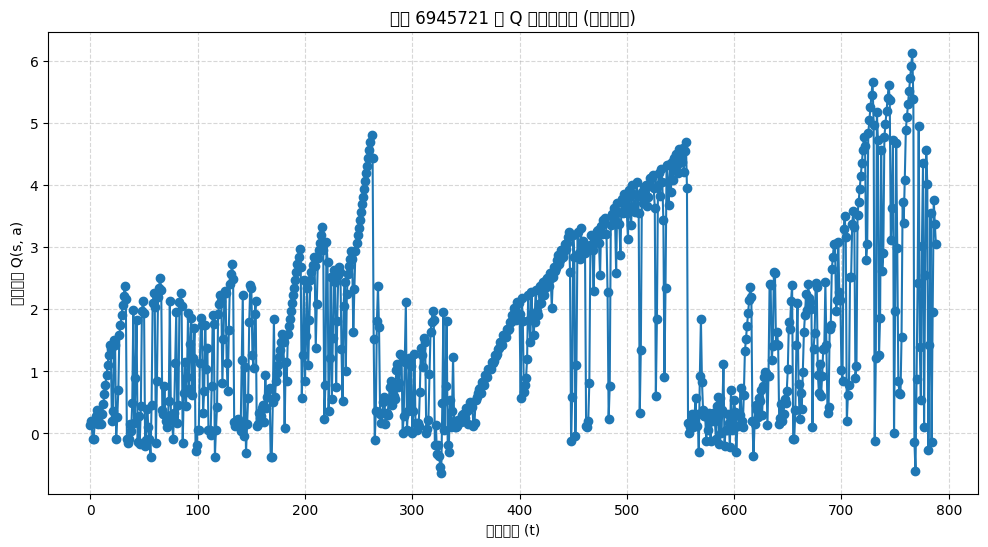


各状态-动作对的 Q 值轨迹 (部分预览):
state   0               1                   2   ...  20          21          \
action  0   14  16  19  1   12  13  15  19  0   ...  19  20  21  0   8   10   
step                                            ...                           
0      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
1      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
2      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
3      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
4      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
5      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
6      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
7      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
8      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN   
9      NaN NaN NaN NaN NaN N

In [59]:
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 可视化学习过程：追踪每一步更新后的 Q 值
# -----------------------------------------------------------------------------

if 'model_summary' not in locals():
    raise RuntimeError("请先运行强化学习建模单元以获取 model_summary。")

# 重新提取最终参数
def unpack_params(theta):
    w = theta[:feature_dim]
    alpha = 1 / (1 + np.exp(-theta[feature_dim]))
    beta = np.exp(theta[feature_dim + 1])
    return w, alpha, beta

if 'final_theta' not in locals():
    raise RuntimeError("缺少 final_theta，请重新运行强化学习建模单元。")

final_w, final_alpha, final_beta = unpack_params(final_theta)

# 重新模拟学习过程
def simulate_learning(w, alpha):
    Q = defaultdict(float)
    records = []

    for t in range(n_transitions):
        s = int(states[t])
        a = int(states[t + 1])
        available_actions = action_sets.get(s, [])
        if not available_actions:
            continue

        q_before = Q[(s, a)]
        reward = float(np.dot(w, state_feature_matrix[a]))

        if t + 1 < n_transitions - 1:
            a_next = int(states[t + 2])
            next_Q = Q[(a, a_next)]
        else:
            next_Q = 0.0

        delta = reward + next_Q - Q[(s, a)]
        Q[(s, a)] += alpha * delta
        records.append({
            'step': t,
            'state': s,
            'action': a,
            'q_before': q_before,
            'q_after': Q[(s, a)],
            'reward': reward,
            'td_error': delta
        })
    return pd.DataFrame(records)

learning_history = simulate_learning(final_w, final_alpha)

if learning_history.empty:
    raise ValueError("学习轨迹为空，请检查输入数据。")

# 可视化：每次更新后的 Q 值
plt.figure(figsize=(12, 6))
plt.plot(learning_history['step'], learning_history['q_after'], marker='o', linestyle='-')
plt.xlabel('更新步数 (t)')
plt.ylabel('更新后的 Q(s, a)')
plt.title(f'用户 {inspect_user} 的 Q 值学习轨迹 (执行动作)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 若希望查看每个状态-动作对的轨迹，可透视表
pivot_q = learning_history.pivot_table(
    index='step', columns=['state', 'action'], values='q_after', aggfunc='last'
)
print("\n各状态-动作对的 Q 值轨迹 (部分预览):")
print(pivot_q.head(10))


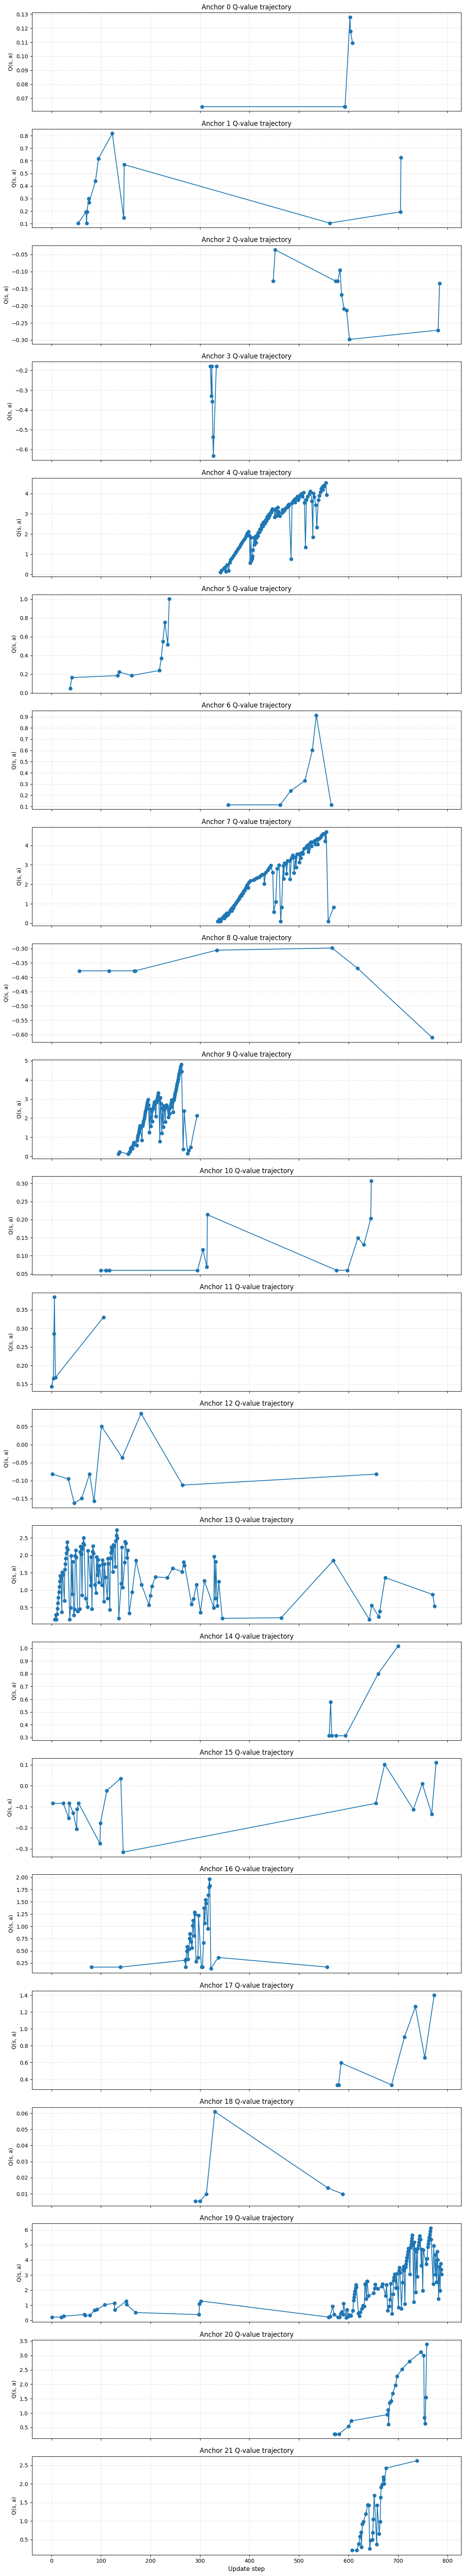

In [60]:
# -----------------------------------------------------------------------------
# Visualize Q-value trajectories per anchor & create interactive anchor map
# -----------------------------------------------------------------------------
import plotly.express as px

if 'learning_history' not in locals():
    raise RuntimeError("learning_history is missing. Please run the learning simulation cell first.")

# --- 1. Line charts for each anchor (destination state) ---
anchor_ids = sorted(learning_history['action'].unique())
if len(anchor_ids) == 0:
    raise ValueError("No anchor transitions found in learning_history.")

fig, axes = plt.subplots(len(anchor_ids), 1, figsize=(12, max(3 * len(anchor_ids), 4)), sharex=True)
if len(anchor_ids) == 1:
    axes = [axes]

for ax, anchor in zip(axes, anchor_ids):
    anchor_history = learning_history[learning_history['action'] == anchor]
    ax.plot(anchor_history['step'], anchor_history['q_after'], marker='o', linestyle='-')
    ax.set_title(f'Anchor {anchor} Q-value trajectory', fontsize=12)
    ax.set_ylabel('Q(s, a)', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel('Update step', fontsize=11)
plt.tight_layout()
plt.show()

# --- 2. Interactive map of anchors for the inspected user ---
user_anchor_geo = (
    stay_with_features_unified[
        (stay_with_features_unified['who'] == inspect_user) &
        (stay_with_features_unified['cluster_id'] != -1)
    ]
    .groupby('cluster_id')
    .agg(
        num_visits=('seqid', 'count'),
        lon=('lambda', 'mean'),
        lat=('phi', 'mean')
    )
    .reset_index()
)

if user_anchor_geo.empty:
    raise ValueError(f"User {inspect_user} has no non-noise anchors to visualize.")

map_fig = px.scatter_mapbox(
    user_anchor_geo,
    lat='lat',
    lon='lon',
    size='num_visits',
    color='cluster_id',
    hover_data={'cluster_id': True, 'num_visits': True, 'lat': ':.5f', 'lon': ':.5f'},
    title=f'Anchor locations for user {inspect_user}',
    zoom=10,
    height=500
)
map_fig.update_layout(mapbox_style='open-street-map', margin={'l': 0, 'r': 0, 't': 40, 'b': 0})
map_fig.show()
